## Exercise - Model Estimation & Evaluation

This is an exercise on parametric model estimation & model evaluation using a Wines dataset.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.tight_layout()
import seaborn as sns
sns.set()
%matplotlib inline

from scipy.stats import norm

### Read from CSV File & Preliminary EDA

After reading from the CSV file, perform EDA for `points` and `price`.

In [2]:
wines_df = pd.read_csv('winemag-sample.csv')
wines_df.head(3)

,title,country,variety,points,price
0,Ca' del Bosco NV Cuvée Prestige Rosé Sparkling...,Italy,Sparkling Blend,89,60.0
1,Robert Hall 2011 Sauvignon Blanc (Paso Robles),US,Sauvignon Blanc,86,14.0
2,Banfi 1999 Brachetto d'Acqui,Italy,Sangiovese,87,23.0


Text(0.5,1,'BOXPLOT OF PRICE OF ALL WINES')

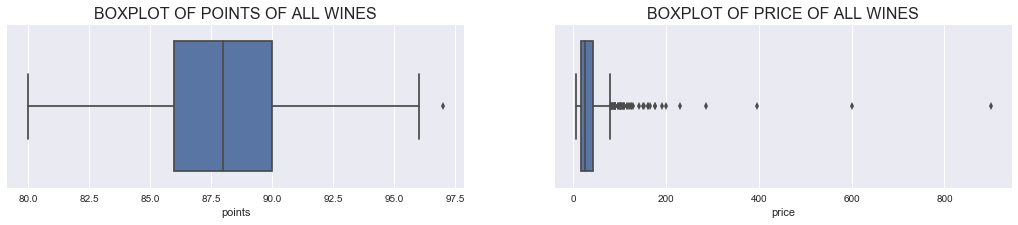

In [3]:
fig = plt.figure(figsize=(18, 3))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
sns.boxplot(wines_df['points'], ax=ax1)
ax1.set_title("BOXPLOT OF POINTS OF ALL WINES", fontsize=16)
sns.boxplot(wines_df['price'], ax=ax2)
ax2.set_title("BOXPLOT OF PRICE OF ALL WINES", fontsize=16)

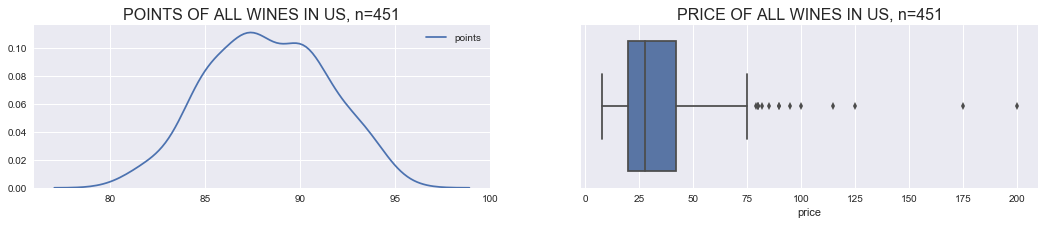

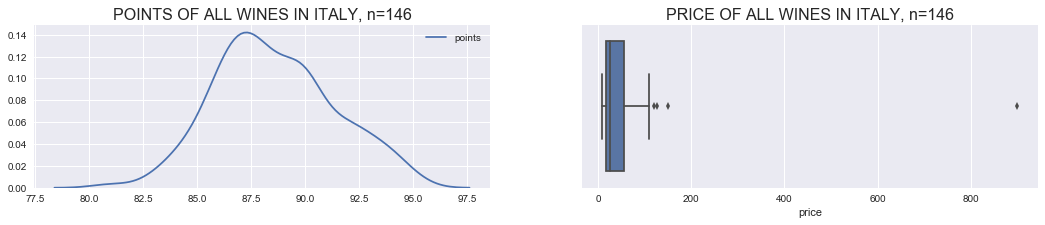

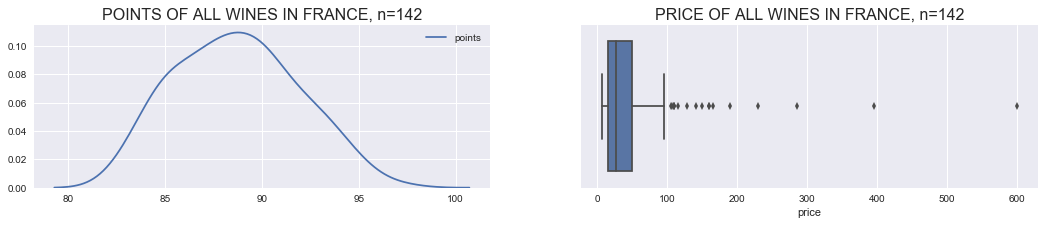

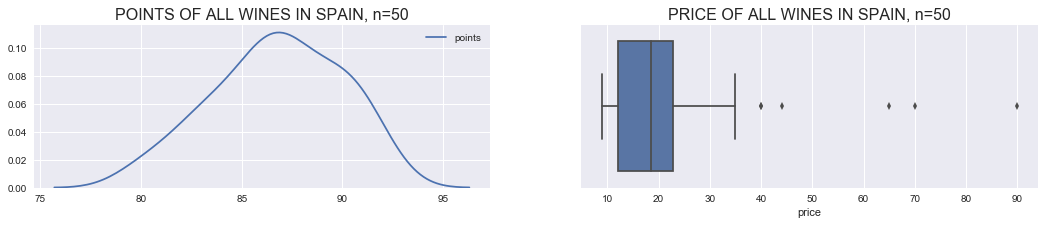

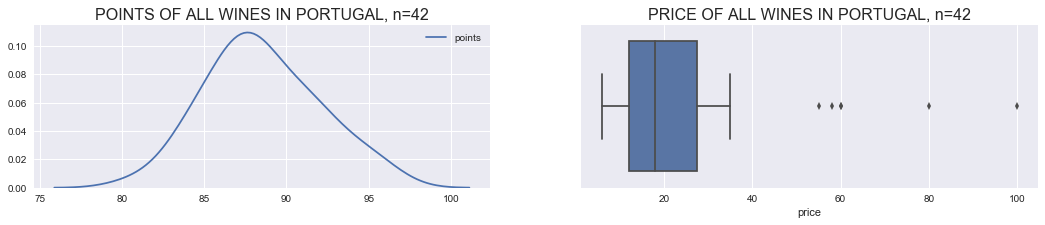

In [4]:
# Find top 5 wine producing countries.
top_countries = wines_df.groupby('country').size().reset_index(name='n').sort_values('n', ascending=False)[:5]['country'].tolist()
for c in top_countries:
    c_df = wines_df[wines_df.country == c]
    fig = plt.figure(figsize=(18, 3))
    ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
    sns.kdeplot(c_df['points'], ax=ax1)
    ax1.set_title("POINTS OF ALL WINES IN %s, n=%d" % (c.upper(), c_df.shape[0]), fontsize=16)
    sns.boxplot(c_df['price'], ax=ax2)
    ax2.set_title("PRICE OF ALL WINES IN %s, n=%d" % (c.upper(), c_df.shape[0]), fontsize=16)
    plt.show()

### Model Fitting (Parametric Estimation)

Let's take a look at the wines from the US.

In [5]:
us_wines_df = wines_df.copy()
us_wines_df = us_wines_df[us_wines_df.country == 'US']
us_wines_df.reset_index(drop=True, inplace=True)
us_wines_points = us_wines_df['points']
sorted_us_wines_points = us_wines_points.sort_values(ascending=True)

From the above plot, it seems that the points have a nice bell curve and fit a normal distribution. Hence, let's attempt to fit the points of US wines to a normal curve.

In [6]:
fitted_mu, fitted_sigma = norm.fit(us_wines_points)
print(fitted_mu,fitted_sigma**2)
print(us_wines_points.mean(),us_wines_points.var())

88.2749445676275 9.74702189271439
88.2749445676275 9.768681941364868


For US Wines points, we now know that $\hat{\mu}=88.275$ and $\hat{\sigma}^2=9.747$. Let's see what the histogram and the fitted line looks like.

In [7]:
# To plot the fitted, use norm.pdf to get the respective probabilities df
points_min, points_max = us_wines_points.min(), us_wines_points.max()
points_x = np.linspace(points_min-2, points_max+2, 100)
fitted_kde = norm.pdf(points_x, fitted_mu, fitted_sigma)
fitted_df = pd.DataFrame({'x' : points_x, 'p_hat' : fitted_kde})

/Users/bryanlim/.pyenv/versions/3.4.8/envs/ds-toolkit/lib/python3.4/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


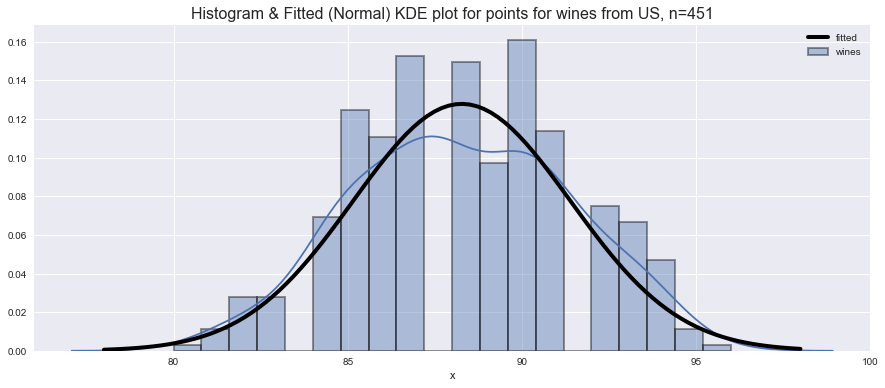

In [8]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)

sns.distplot(us_wines_points, bins=20, hist_kws=dict(edgecolor="k", linewidth=2), ax=ax)
fitted_df.plot(kind='line', x='x', y='p_hat', linewidth=4, color='black', ax=ax)

ax.set_title("Histogram & Fitted (Normal) KDE plot for points for wines from US, n=%d" % us_wines_points.count(), fontsize=16)
ax.legend(['fitted', 'wines',])
plt.show()

### Model Evaluation: Graphical Methods
Now, we know that the fitted is a fair approximation to the empirical. However, are there better tools for us to evaluate this model well? We first use graphical methods to evaluate, and the first plot is the p-p plot.

In [9]:
empirical_df = pd.DataFrame({'x' : sorted_us_wines_points})
empirical_df.reset_index(inplace=True, drop=True)
empirical_df['i'] = empirical_df.index+1
empirical_df['p_i'] = empirical_df['i'].apply(lambda x : x/(empirical_df['x'].count() + 1))
print(empirical_df.head())

    x  i       p_i
0  80  1  0.002212
1  81  2  0.004425
2  81  3  0.006637
3  81  4  0.008850
4  81  5  0.011062


In [10]:
min_prob = empirical_df.groupby('x')['p_i'].min().reset_index(name='p_i')
max_prob = empirical_df.groupby('x')['p_i'].max().reset_index(name='p_i')
pp_df = min_prob.append(max_prob).sort_values(['x', 'p_i'])
pp_df.drop_duplicates(subset=['x', 'p_i'], inplace=True)
pp_df['p_fitted'] = norm.cdf(pp_df['x'], fitted_mu, fitted_sigma)
print(pp_df.head())
print(pp_df.tail())

    x       p_i  p_fitted
0  80  0.002212  0.004019
1  81  0.004425  0.009898
1  81  0.011062  0.009898
2  82  0.013274  0.022221
2  82  0.033186  0.022221
     x       p_i  p_fitted
14  94  0.951327  0.966656
14  94  0.986726  0.966656
15  95  0.988938  0.984383
15  95  0.995575  0.984383
16  96  0.997788  0.993327


In [11]:
forty_five_line_df = pd.DataFrame({'x' : [0,1], 'y' : [0,1]})
print(forty_five_line_df)

   x  y
0  0  0
1  1  1


Text(0.5,1,'p-p plot for points')

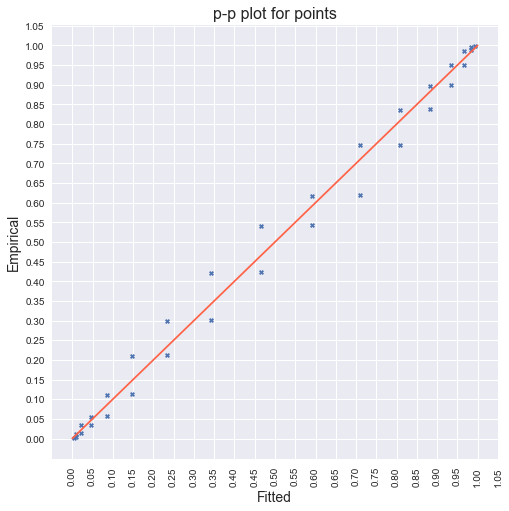

In [12]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

pp_df.plot(kind='scatter', x='p_fitted', y='p_i', ax=ax, marker='X')
forty_five_line_df.plot(kind='line', x='x', y='y', ax=ax, color='tomato')
ax.set_ylabel("Empirical", fontsize=14)
ax.set_xticks(np.arange(0, 1.1, 0.05))
ax.set_xticklabels(['%.2f' % f for f in np.arange(0, 1.1, 0.05)], rotation=90)
ax.set_yticks(np.arange(0, 1.1, 0.05))
ax.set_xlabel("Fitted", fontsize=14)
ax.legend('')
ax.set_title("p-p plot for points", fontsize=16)

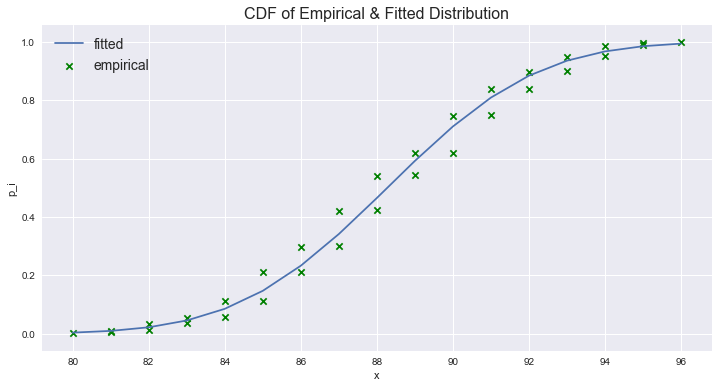

In [13]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
pp_df.plot(kind='scatter', x='x', y='p_i', marker='x', ax=ax, s=40, color='green')
pp_df.plot(kind='line', x='x', y='p_fitted', marker='x', ax=ax,)
ax.set_title("CDF of Empirical & Fitted Distribution", fontsize=16)
ax.legend(['fitted', 'empirical'], fontsize=14)